# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

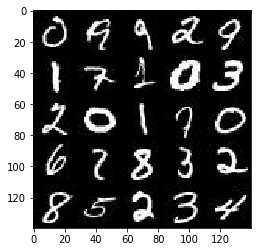

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

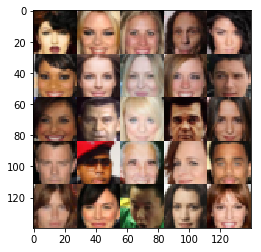

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        
        # Input layer
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha = 0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=3, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
              
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

## Label Smoothing

If it's real logit then label it randomly between 0.85 and 1.0
If it's fake logit then label it randomly between 0 and 0.15

In [8]:
import numpy as np
print(np.random.uniform(0.9,0.99))
print(np.random.uniform(0.01,0.2))

0.9215392011014758
0.1514121797509727


In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Label Smoothing
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * np.random.uniform(0.85,0.99)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake) * np.random.uniform(0.0,0.15)))

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(g_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(d_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    losses = []
    
    # Initialize variables
    input_real, input_z, lr_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #lr_rate = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                # Convert -0.5 to 0.5 to -1 to 1 for Tanh 
                batch_images = batch_images * 2
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                #_ = sess.run(g_train_opt, feed_dict={input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z, 
                                                     lr_rate : learning_rate})
                
                if steps % 100 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))   
                    
                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)  
        
        # Final Output
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6068... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 1.7800
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.3236... Generator Loss: 0.6829
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.9275


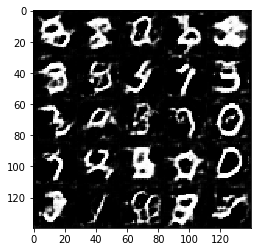

Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.6924
Epoch 1/2... Discriminator Loss: 1.1923... Generator Loss: 0.7274
Epoch 1/2... Discriminator Loss: 0.7145... Generator Loss: 2.1113
Epoch 1/2... Discriminator Loss: 0.9517... Generator Loss: 1.2519
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 1.9123


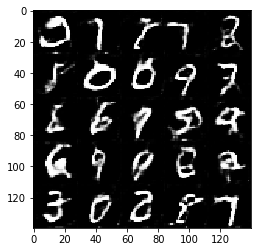

Epoch 2/2... Discriminator Loss: 1.0054... Generator Loss: 1.6603
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 0.8995
Epoch 2/2... Discriminator Loss: 1.5695... Generator Loss: 3.0920
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 2.6602
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.3473


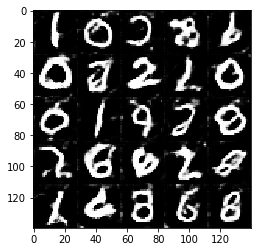

Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 1.3185
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.9187
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 1.2406


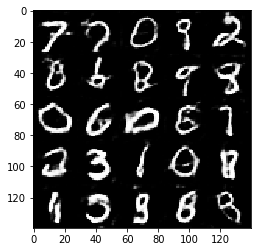

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.5892... Generator Loss: 0.3489
Epoch 1/2... Discriminator Loss: 1.5723... Generator Loss: 2.4289
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 0.7940
Epoch 1/2... Discriminator Loss: 1.7602... Generator Loss: 0.3470
Epoch 1/2... Discriminator Loss: 1.8418... Generator Loss: 2.5232


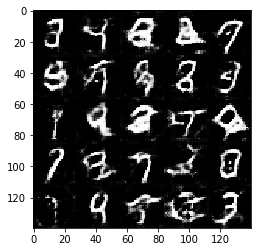

Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 1.4978
Epoch 1/2... Discriminator Loss: 1.0371... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 0.8407... Generator Loss: 1.3808


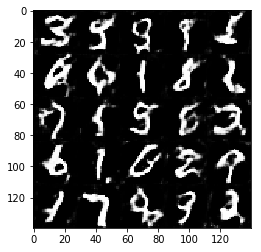

Epoch 2/2... Discriminator Loss: 0.5256... Generator Loss: 1.6687
Epoch 2/2... Discriminator Loss: 0.7485... Generator Loss: 1.1722
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 2.1937
Epoch 2/2... Discriminator Loss: 0.7832... Generator Loss: 1.7222
Epoch 2/2... Discriminator Loss: 1.1446... Generator Loss: 0.8409


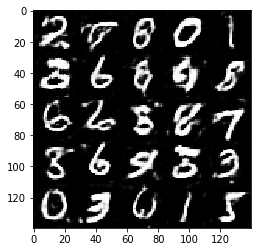

Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.6336
Epoch 2/2... Discriminator Loss: 1.4886... Generator Loss: 3.5253
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.6214


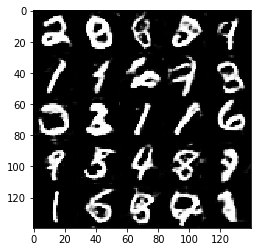

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.9363... Generator Loss: 0.2193
Epoch 1/2... Discriminator Loss: 1.8401... Generator Loss: 1.8053
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.7807
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 2.0250... Generator Loss: 0.1876


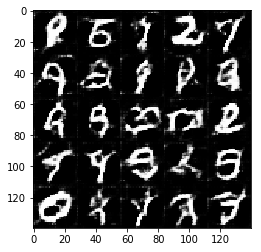

Epoch 1/2... Discriminator Loss: 1.2900... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.2511... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.0343... Generator Loss: 0.9176
Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.1921
Epoch 2/2... Discriminator Loss: 0.9267... Generator Loss: 1.0359


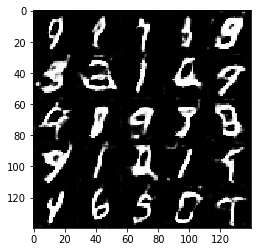

Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 1.5368
Epoch 2/2... Discriminator Loss: 1.1707... Generator Loss: 0.6135
Epoch 2/2... Discriminator Loss: 0.7875... Generator Loss: 1.6896
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.8004
Epoch 2/2... Discriminator Loss: 1.2038... Generator Loss: 0.5628


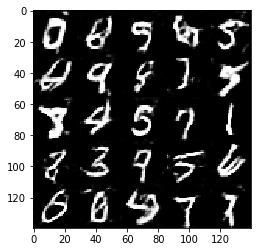

Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 0.7254... Generator Loss: 1.7916
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 0.8191


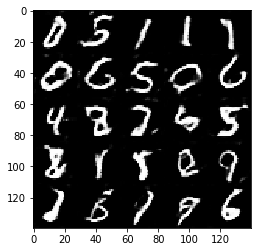

In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.9454... Generator Loss: 0.2732
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 1.5996
Epoch 1/2... Discriminator Loss: 1.1422... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.5896... Generator Loss: 0.3630
Epoch 1/2... Discriminator Loss: 1.4311... Generator Loss: 0.4398


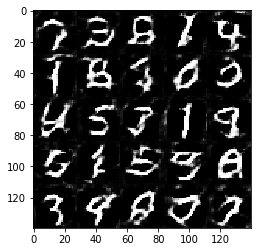

Epoch 1/2... Discriminator Loss: 1.3881... Generator Loss: 2.4485
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 1.2394
Epoch 1/2... Discriminator Loss: 1.1292... Generator Loss: 0.6583
Epoch 1/2... Discriminator Loss: 2.2173... Generator Loss: 0.2121
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.2698


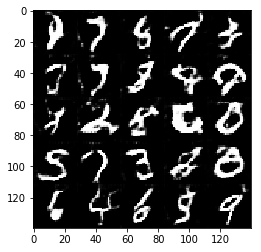

Epoch 2/2... Discriminator Loss: 0.5899... Generator Loss: 2.3328
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.6350
Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 1.5071
Epoch 2/2... Discriminator Loss: 0.6495... Generator Loss: 1.5962
Epoch 2/2... Discriminator Loss: 0.8697... Generator Loss: 1.5754


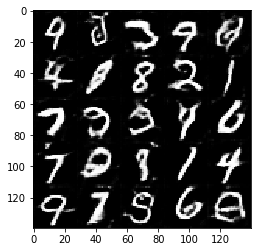

Epoch 2/2... Discriminator Loss: 0.5618... Generator Loss: 1.5598
Epoch 2/2... Discriminator Loss: 0.4372... Generator Loss: 1.7073
Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.5062


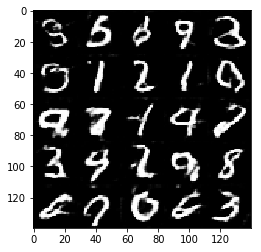

In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.5271... Generator Loss: 0.5542
Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.9537
Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.7691
Epoch 1/2... Discriminator Loss: 1.2782... Generator Loss: 0.5238
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.2914


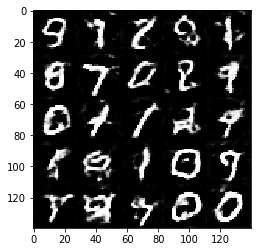

Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 0.8359
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.6114
Epoch 1/2... Discriminator Loss: 0.9991... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.2821... Generator Loss: 0.4940
Epoch 2/2... Discriminator Loss: 1.0882... Generator Loss: 2.1289


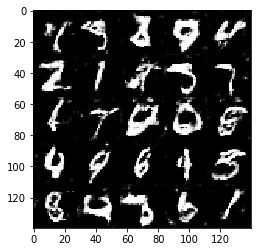

Epoch 2/2... Discriminator Loss: 0.8743... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 0.6898
Epoch 2/2... Discriminator Loss: 0.7439... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 2.7275... Generator Loss: 4.6980
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 0.8235


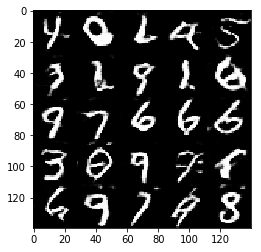

Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.9143
Epoch 2/2... Discriminator Loss: 0.6759... Generator Loss: 1.2273
Epoch 2/2... Discriminator Loss: 1.0915... Generator Loss: 0.6335


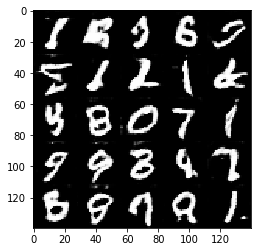

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.3086... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.3844
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 0.6664
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.0227
Epoch 1/2... Discriminator Loss: 1.0972... Generator Loss: 0.6097


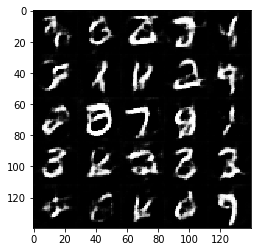

Epoch 1/2... Discriminator Loss: 0.9886... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 0.8607... Generator Loss: 1.1705
Epoch 1/2... Discriminator Loss: 1.2098... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.4401
Epoch 2/2... Discriminator Loss: 0.8358... Generator Loss: 1.0133


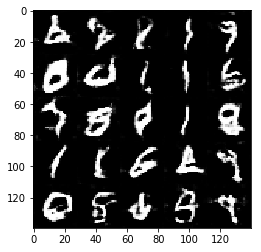

Epoch 2/2... Discriminator Loss: 1.0315... Generator Loss: 0.5804
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.5864
Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 0.8755
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 1.5625
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 0.9368


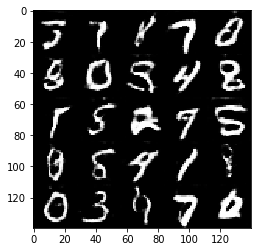

Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 1.1675... Generator Loss: 0.4760
Epoch 2/2... Discriminator Loss: 1.2547... Generator Loss: 0.5061


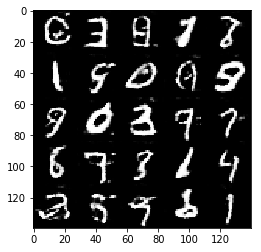

In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 0.4694
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.8671


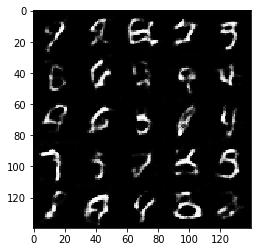

Epoch 1/2... Discriminator Loss: 3.1309... Generator Loss: 0.0683
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 1.1817... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.2437... Generator Loss: 0.5054


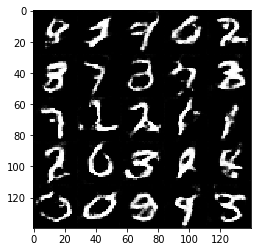

Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.5919
Epoch 2/2... Discriminator Loss: 1.2133... Generator Loss: 0.5773
Epoch 2/2... Discriminator Loss: 0.8940... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.7631
Epoch 2/2... Discriminator Loss: 0.9942... Generator Loss: 0.7577


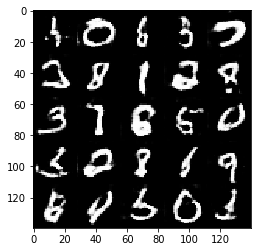

Epoch 2/2... Discriminator Loss: 0.9626... Generator Loss: 0.8353
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 0.7666
Epoch 2/2... Discriminator Loss: 0.7893... Generator Loss: 1.1833


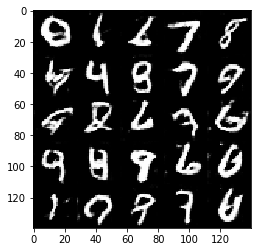

In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 1.4760... Generator Loss: 0.4177
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.7122
Epoch 1/2... Discriminator Loss: 1.7079... Generator Loss: 0.3205
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 1.9427
Epoch 1/2... Discriminator Loss: 1.1387... Generator Loss: 0.6917


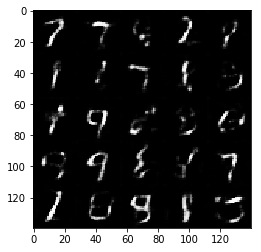

Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 0.8743
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.2375
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 1.2561... Generator Loss: 0.5632


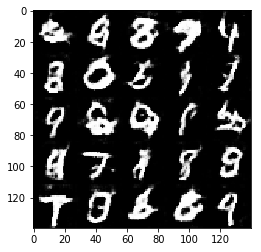

Epoch 2/2... Discriminator Loss: 0.8018... Generator Loss: 1.1500
Epoch 2/2... Discriminator Loss: 0.8602... Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.1015
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 2.0699
Epoch 2/2... Discriminator Loss: 0.7666... Generator Loss: 1.3823


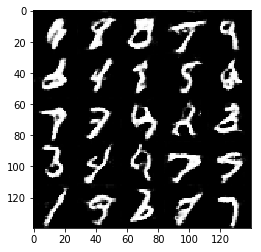

Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 0.9936
Epoch 2/2... Discriminator Loss: 0.8586... Generator Loss: 0.9852
Epoch 2/2... Discriminator Loss: 0.6360... Generator Loss: 1.5306


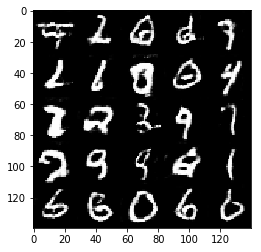

In [20]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

## Experimental Results

As you can see from the above parameter combinations, it looks like with batch_size = 64, z_dim = 100 and beta1 = 0.5 the best learning_rate = 0.0004.  I'll apply this combination to the Celebrity Photos GANs.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 0.5246... Generator Loss: 1.4199
Epoch 1/2... Discriminator Loss: 2.4373... Generator Loss: 3.2593
Epoch 1/2... Discriminator Loss: 0.7671... Generator Loss: 1.0790
Epoch 1/2... Discriminator Loss: 1.2296... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 1.7028


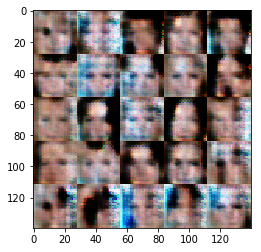

Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 2.4926
Epoch 1/2... Discriminator Loss: 1.7963... Generator Loss: 0.4318
Epoch 1/2... Discriminator Loss: 1.3173... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 0.7166... Generator Loss: 1.3974
Epoch 1/2... Discriminator Loss: 0.9430... Generator Loss: 0.7319


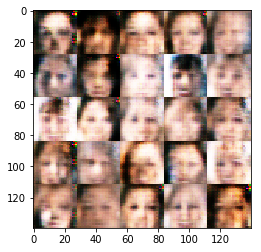

Epoch 1/2... Discriminator Loss: 1.5365... Generator Loss: 0.3683
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.7868... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 1.0749
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.9059


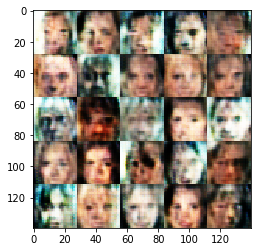

Epoch 1/2... Discriminator Loss: 0.9857... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.1725... Generator Loss: 0.8236
Epoch 1/2... Discriminator Loss: 1.2421... Generator Loss: 0.6633
Epoch 1/2... Discriminator Loss: 1.2066... Generator Loss: 0.8632
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 2.4371


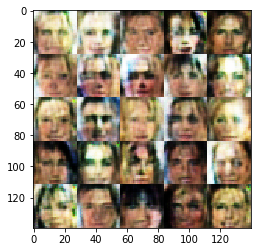

Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 1.9245
Epoch 1/2... Discriminator Loss: 1.1277... Generator Loss: 0.8445
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.9067
Epoch 1/2... Discriminator Loss: 0.5250... Generator Loss: 1.7528
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 1.0597


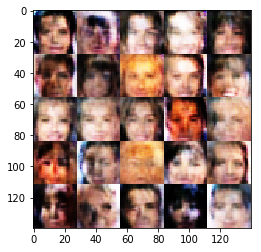

Epoch 1/2... Discriminator Loss: 1.0637... Generator Loss: 1.2190
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.8019
Epoch 1/2... Discriminator Loss: 0.6691... Generator Loss: 1.1336
Epoch 1/2... Discriminator Loss: 0.8474... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 1.4394


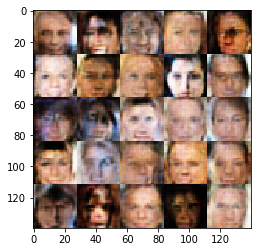

Epoch 1/2... Discriminator Loss: 0.9379... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 0.9361
Epoch 2/2... Discriminator Loss: 1.2111... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.3650... Generator Loss: 0.4053
Epoch 2/2... Discriminator Loss: 1.0040... Generator Loss: 0.9879


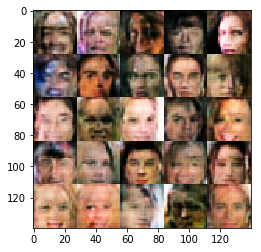

Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.0719... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.8423
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 1.1777
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7491


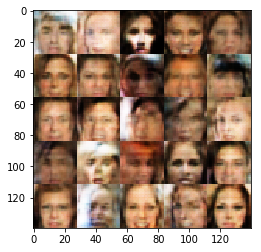

Epoch 2/2... Discriminator Loss: 1.1196... Generator Loss: 0.8018
Epoch 2/2... Discriminator Loss: 0.9290... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 1.1808... Generator Loss: 0.9960
Epoch 2/2... Discriminator Loss: 1.1646... Generator Loss: 0.8911


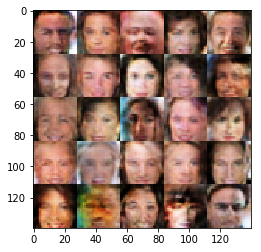

Epoch 2/2... Discriminator Loss: 1.3200... Generator Loss: 0.4822
Epoch 2/2... Discriminator Loss: 1.5215... Generator Loss: 2.6655
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 1.3575
Epoch 2/2... Discriminator Loss: 0.5849... Generator Loss: 2.0745
Epoch 2/2... Discriminator Loss: 1.6186... Generator Loss: 0.3342


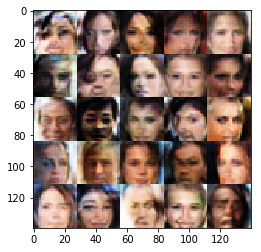

Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 2.1826
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 1.6371... Generator Loss: 0.2934
Epoch 2/2... Discriminator Loss: 1.0125... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.2250... Generator Loss: 0.6470


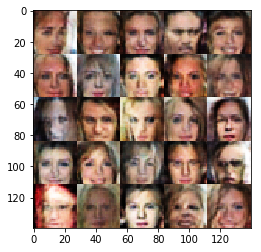

Epoch 2/2... Discriminator Loss: 1.0473... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 1.3385... Generator Loss: 0.8884
Epoch 2/2... Discriminator Loss: 1.1592... Generator Loss: 0.7289
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.8232
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.9641


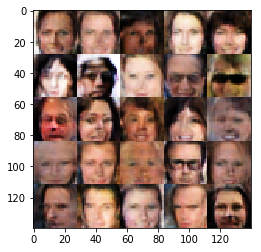

Epoch 2/2... Discriminator Loss: 1.0965... Generator Loss: 0.9242
Epoch 2/2... Discriminator Loss: 1.1411... Generator Loss: 0.7542
Epoch 2/2... Discriminator Loss: 1.2005... Generator Loss: 0.6558


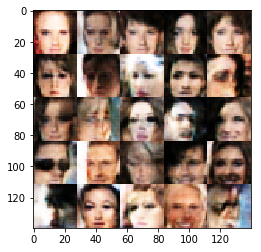

In [21]:
batch_size = 64
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.